In [1]:
from isaac_victor_envs.utils import get_assets_dir
from isaac_victor_envs.tasks.allegro import AllegroScrewdriverTurningEnv
# from isaac_victor_envs.tasks.allegro_ros import RosAllegroValveTurningEnv

import numpy as np
import pickle
from tqdm.notebook import tqdm

import scipy
import torch
import time
import copy
import yaml
import pathlib
from functools import partial
import sys

import pytorch_volumetric as pv
import pytorch_kinematics as pk
import pytorch_kinematics.transforms as tf
from torch.func import vmap, jacrev, hessian, jacfwd
# import pytorch3d.transforms as tf

import matplotlib.pyplot as plt
from ccai.utils.allegro_utils import *
# from allegro_valve_roll import AllegroValveTurning, AllegroContactProblem, PositionControlConstrainedSVGDMPC, \
#    add_trajectories, add_trajectories_hardware

from ccai.allegro_contact import AllegroManipulationProblem, PositionControlConstrainedSVGDMPC, add_trajectories, \
    add_trajectories_hardware
from ccai.allegro_screwdriver_problem_diffusion import AllegroScrewdriverDiff
from scipy.spatial.transform import Rotation as R

# from ccai.mpc.ipopt import IpoptMPC
# from ccai.problem import IpoptProblem
# from ccai.models.trajectory_samplers import TrajectorySampler

import matplotlib
import matplotlib.pyplot as plt

from typing import List, Tuple, Dict, Any

%matplotlib inline

Importing module 'gym_38' (/home/abhinav/Downloads/IsaacGym_Preview_4_Package/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/abhinav/Downloads/IsaacGym_Preview_4_Package/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
PyTorch version 2.4.0+cu121
Device count 1
/home/abhinav/Downloads/IsaacGym_Preview_4_Package/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /home/abhinav/.cache/torch_extensions/py38_cu121 as PyTorch extensions root...
Emitting ninja build file /home/abhinav/.cache/torch_extensions/py38_cu121/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
obj_dof = 3
# config = yaml.safe_load(pathlib.Path(f'../examples/config/{sys.argv[1]}.yaml').read_text())
config = yaml.safe_load(pathlib.Path(f'../examples/config/screwdriver/allegro_screwdriver_csvto_OOD_ID_test.yaml').read_text())
config['visualize'] = False
config['device'] = 'cpu'

if config['mode'] == 'hardware':
    env = RosAllegroValveTurningEnv(1, control_mode='joint_impedance',
                                    use_cartesian_controller=False,
                                    viewer=True,
                                    steps_per_action=60,
                                    friction_coefficient=1.0,
                                    device=config['sim_device'],
                                    valve=config['object_type'],
                                    video_save_path=img_save_dir,
                                    joint_stiffness=config['kp'],
                                    fingers=config['fingers'],
                                    )
else:
    if not config['visualize']:
        img_save_dir = None

    env = AllegroScrewdriverTurningEnv(1, control_mode='joint_impedance',
                                        use_cartesian_controller=False,
                                        viewer=config['visualize'],
                                        steps_per_action=60,
                                        friction_coefficient=config['friction_coefficient'] * 1.05,
                                        # friction_coefficient=1.0,  # DEBUG ONLY, set the friction very high
                                        device=config['sim_device'],
                                        video_save_path=img_save_dir,
                                        joint_stiffness=config['kp'],
                                        fingers=config['fingers'],
                                        )

sim, gym, viewer = env.get_sim()

state = env.get_state()
# try:
#     while True:
#         start = env.get_state()['q'][:, :-1]
#         env.step(start)
#         print('waiting for you to finish camera adjustment, ctrl-c when done')
#         time.sleep(0.1)
# except KeyboardInterrupt:
#     pass

sim_env = None
ros_copy_node = None
if config['mode'] == 'hardware':
    sim_env = env
    from hardware.hardware_env import HardwareEnv

    env = HardwareEnv(sim_env.default_dof_pos[:, :16], finger_list=['index', 'thumb'], kp=config['kp'])
    env.world_trans = sim_env.world_trans
    env.joint_stiffness = sim_env.joint_stiffness
    env.device = sim_env.device
    env.valve_pose = sim_env.valve_pose
elif config['mode'] == 'hardware_copy':
    from hardware.hardware_env import RosNode

    ros_copy_node = RosNode()

results = {}

# set up the kinematic chain
asset = f'{get_assets_dir()}/xela_models/allegro_hand_right.urdf'
ee_names = {
    'index': 'allegro_hand_hitosashi_finger_finger_0_aftc_base_link',
    'middle': 'allegro_hand_naka_finger_finger_1_aftc_base_link',
    'ring': 'allegro_hand_kusuri_finger_finger_2_aftc_base_link',
    'thumb': 'allegro_hand_oya_finger_3_aftc_base_link',
}
config['ee_names'] = ee_names
config['obj_dof'] = 3

screwdriver_asset = f'{get_assets_dir()}/screwdriver/screwdriver.urdf'

chain = pk.build_chain_from_urdf(open(asset).read())
screwdriver_chain = pk.build_chain_from_urdf(open(screwdriver_asset).read())
frame_indices = [chain.frame_to_idx[ee_names[finger]] for finger in config['fingers']]  # combined chain
frame_indices = torch.tensor(frame_indices)
state2ee_pos = partial(state2ee_pos, fingers=config['fingers'], chain=chain, frame_indices=frame_indices,
                        world_trans=env.world_trans)

forward_kinematics = partial(chain.forward_kinematics,
                                frame_indices=frame_indices)  # full_to= _partial_state = partial(full_to_partial_state, fingers=config['fingers'])
partial_to_full_state = partial(partial_to_full_state, fingers=config['fingers'])

controller = 'csvgd'
goal = - 0.5 * torch.tensor([0, 0, np.pi])
# set up params
params = config.copy()
params.pop('controllers')
params.update(config['controllers'][controller])
params['device'] = 'cpu'
params['controller'] = controller
params['valve_goal'] = goal.to(device=params['device'])
params['chain'] = chain.to(device=params['device'])
object_location = torch.tensor([0, 0, 1.205]).to(
    params['device'])  # TODO: confirm if this is the correct location
params['object_location'] = object_location

num_fingers = len(params['fingers'])
state = env.get_state()
start = state['q'].reshape(4 * num_fingers + 4).to(device=params['device'])
if 'csvgd' in params['controller']:
    # index finger is used for stability
    if 'index' in params['fingers']:
        fingers = params['fingers']
    else:
        fingers = ['index'] + params['fingers']

pregrasp_problem = AllegroScrewdriverDiff(
    start=start[:4 * num_fingers + obj_dof],
    goal=params['valve_goal'] * 0,
    T=params['T'],
    chain=params['chain'],
    device=params['device'],
    object_asset_pos=env.table_pose,
    object_location=params['object_location'],
    object_type=params['object_type'],
    world_trans=env.world_trans,
    regrasp_fingers=fingers,
    contact_fingers=[],
    obj_dof=obj_dof,
    obj_joint_dim=1,
    optimize_force=params['optimize_force'],
)
# finger gate index
index_regrasp_problem = AllegroScrewdriverDiff(
    start=start[:4 * num_fingers + obj_dof],
    goal=params['valve_goal'] * 0,
    T=params['T'],
    chain=params['chain'],
    device=params['device'],
    object_asset_pos=env.table_pose,
    object_location=params['object_location'],
    object_type=params['object_type'],
    world_trans=env.world_trans,
    regrasp_fingers=['index'],
    contact_fingers=['middle', 'thumb'],
    obj_dof=obj_dof,
    obj_joint_dim=1,
    optimize_force=params['optimize_force'],
    default_dof_pos=env.default_dof_pos[:, :16]
)
thumb_and_middle_regrasp_problem = AllegroScrewdriverDiff(
    start=start[:4 * num_fingers + obj_dof],
    goal=params['valve_goal'] * 0,
    T=params['T'],
    chain=params['chain'],
    device=params['device'],
    object_asset_pos=env.table_pose,
    object_location=params['object_location'],
    object_type=params['object_type'],
    world_trans=env.world_trans,
    contact_fingers=['index'],
    regrasp_fingers=['middle', 'thumb'],
    obj_dof=obj_dof,
    obj_joint_dim=1,
    optimize_force=params['optimize_force'],
    default_dof_pos=env.default_dof_pos[:, :16]
)
turn_problem = AllegroScrewdriverDiff(
    start=start[:4 * num_fingers + obj_dof],
    goal=params['valve_goal'] * 0,
    T=params['T'],
    chain=params['chain'],
    device=params['device'],
    object_asset_pos=env.table_pose,
    object_location=params['object_location'],
    object_type=params['object_type'],
    world_trans=env.world_trans,
    contact_fingers=['index', 'middle', 'thumb'],
    obj_dof=obj_dof,
    obj_joint_dim=1,
    optimize_force=params['optimize_force'],
    default_dof_pos=env.default_dof_pos[:, :16]
)
contact_mode_dict = {0: 'pregrasp', 2: 'index', 1: 'thumb_middle', 3: 'turn'}
t = 3
# with open(data_path / f'constraint_violations.p', 'wb') as f:
#     pickle.dump(constraint_violations_all, f)


Not connected to PVD
Physics Engine: PhysX
Physics Device: cpu
GPU Pipeline: disabled
Using VHACD cache directory '/home/abhinav/.isaacgym/vhacd'
Found existing convex decomposition for mesh '/home/abhinav/Documents/git_packages/isaacgym-arm-envs/isaac_victor_envs/assets/xela_models/mesh/allegro/base_ns.stl'
Found existing convex decomposition for mesh '/home/abhinav/Documents/git_packages/isaacgym-arm-envs/isaac_victor_envs/assets/xela_models/mesh/allegro/link_1.0.stl'
Found existing convex decomposition for mesh '/home/abhinav/Documents/git_packages/isaacgym-arm-envs/isaac_victor_envs/assets/xela_models/mesh/ft_c.stl'


/home/abhinav/Documents/git_packages/pytorch_volumetric/src/pytorch_volumetric/sdf.py:1319: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache = torch.load(dbpath)
/home/ab

In [3]:
def calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits, proj_diff=True):
    if not torch.is_tensor(to_eval):
        to_eval = torch.tensor(to_eval).to(device=params['device'])
    else:
        to_eval = to_eval.to(device=params['device'])
    if c_state == 'pregrasp':
        # Call _con_eq and _con_ineq to get constraint violation
        prob = pregrasp_problem
        inds = torch.arange(27)

    elif c_state == 'index':
        prob = index_regrasp_problem
        # Need to rearrange (index, middle, thumb)
        if plans_or_inits == 'plans':
            inds = torch.cat((torch.arange(27), torch.arange(30, 36)))
        else:
            inds = torch.arange(33)

    elif c_state == 'thumb_middle':
        prob = thumb_and_middle_regrasp_problem
        inds = torch.arange(30)

    elif c_state == 'turn':
        prob = turn_problem
        inds = torch.arange(36)

    prob._preprocess(to_eval, projected_diffusion=proj_diff)
    g, _, _ = prob._con_eq(to_eval[..., inds], compute_grads=False, compute_hess=False, verbose=True, projected_diffusion=proj_diff)
    h, _, _ = prob._con_ineq(to_eval[..., inds], compute_grads=False, compute_hess=False, verbose=True, projected_diffusion=proj_diff)
    if g is not None:
        g = g.cpu()
    if h is not None:
        h = h.cpu()

    info = {'g': g, 'h': h, 'c_state': c_state}
    info_list.append(info)
    return info_list

def gen_constraint_data(plans_or_inits, constraint_violations, path, traj_data=[None]*10):
    for trial in tqdm(range(1, 11)):
        info_list = []
        try:
            if traj_data[trial-1] is None:
                try:
                    with open(path + f'/trial_{trial}/traj_data.p', 'rb') as f:
                        data = pickle.load(f)
                except:
                    continue
        except:
            continue
        else:
            data = traj_data[trial-1]
        if plans_or_inits == 'plans':
            data[t]['plans'] = torch.tensor(data[t]['plans']).to(device=params['device'])
            loop_range = data[t]['plans'].shape[0]
        elif plans_or_inits == 'optimizer_paths':
            loop_range = len(data[t]['optimizer_paths'])
        elif plans_or_inits == 'planned_inits':
            loop_range = len(data[t]['planned_inits'])
        else:
            loop_range = len(data[t]['inits'])
        for i in (range(loop_range)):
            c_state = contact_mode_dict[data[t]['contact_state'][i].sum().item()]
            to_eval = data[t][plans_or_inits][i]
            # if plans_or_inits == 'optimizer_paths':
            #     to_eval = to_eval[0].flatten(0, 1)
            # info_list = calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits)
            if plans_or_inits in {'plans', 'inits', 'traj'}:
                info_list = calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits, proj_diff=False)
            else:
                to_eval = to_eval[0]
                all_infos = []
                for csvto_tstep in (range(data[t]['optimizer_paths'][i][0].shape[0])):
                    all_infos = calc_info(c_state, to_eval[csvto_tstep], all_infos, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits, proj_diff=False)
                info_list.append(all_infos)
        constraint_violations.append(info_list)

In [4]:
def calculate_recovery_metrics(
    final_likelihood: List[List[float]], 
    pre_action_likelihoods: List[List[float]],
    dropped_info: List[bool] = None,
    threshold: float = -160.0
) -> Tuple[List[int], List[int], List[int], List[float], List[bool]]:
    """
    Calculate recovery metrics from likelihood time series data.
    
    Args:
        final_likelihood: Nested list of likelihood values per trial and step
        dropped_info: Optional list of booleans indicating if the object was dropped
        threshold: Threshold below which state is considered in need of recovery
        
    Returns:
        Tuple containing:
            - one_step_recovery_success: Binary indicators of one-step recovery success
            - eventual_recovery_success: Binary indicators of eventual recovery success
            - num_recovery_attempts_to_recover: Number of attempts needed for recovery
            - recovery_improvement: Improvement in likelihood during recovery
            - dropped_recovery: Indicators if recovery ended due to dropping
    """
    one_step_recovery_success = []
    recovery_improvement = []
    dropped_recovery = []
    
    eventual_recovery_success = []
    recovery_improvement_block = []
    dropped_recovery_block = []
    num_recovery_attempts_to_recover = []

    
    for trial_idx, trial in enumerate(final_likelihood):
        # print(trial_idx+1)
        # print(trial)
        # print( [trial_idx])
        # trial = sum(trial, [])
        trial = [l for l in trial if None not in l and len(l) > 0]
        # trial.insert(0, [pre_action_likelihoods[trial_idx][0][-1]])
        for k in range(len(trial)):
            if len(trial[k]) == 0 and len(pre_action_likelihoods[trial_idx][k]) > 0:
                trial[k].append(pre_action_likelihoods[trial_idx][k][-1])
            # elif len(trial[k]) == 0:
            #     trial[k].append(-200) # Placeholder
        # print(trial)
        # print()

        np_trial = np.array(trial)
        recovery_blocks = []
        is_in_recovery_block = False
        current_block = {}
        
        # Check if dropped_info is available for this trial
        trial_dropped = dropped_info[trial_idx] if dropped_info and trial_idx < len(dropped_info) else False
        
        for step_idx in range(np_trial.shape[0]):
            likelihood = np_trial[step_idx]
            # print(likelihood)
            
            # Start of a recovery block
            if not is_in_recovery_block and likelihood < threshold:
                is_in_recovery_block = True
                current_block = {
                    'start_idx': step_idx,
                    'start_likelihood': likelihood,
                    'attempts': 1  # This is the first attempt
                }
            
            # Continue an existing recovery block
            elif is_in_recovery_block and ( likelihood < threshold):
                current_block['attempts'] += 1
                # if likelihood is None:
                #     likelihood = -160
                recovery_improvement.append(
                    likelihood - current_block['start_likelihood']
                )
                dropped_recovery.append(False)  # Successful recovery wasn't due to dropping
                one_step_recovery_success.append(0)
            
            # End of a recovery block - successful
            elif is_in_recovery_block and likelihood >= threshold:
                is_in_recovery_block = False
                current_block['end_idx'] = step_idx
                current_block['end_likelihood'] = likelihood
                current_block['success'] = True
                current_block['duration'] = step_idx - current_block['start_idx']
                current_block['dropped'] = False
                recovery_blocks.append(current_block)
                
                # Calculate one-step recovery success (duration = 1)
                one_step_success = int(current_block['duration'] == 1)
                one_step_recovery_success.append(one_step_success)
                
                # Track other metrics
                num_recovery_attempts_to_recover.append(current_block['attempts'])
                eventual_recovery_success.append(1)
                recovery_improvement_block.append(
                    current_block['end_likelihood'] - current_block['start_likelihood']
                )
                recovery_improvement.append(
                    current_block['end_likelihood'] - current_block['start_likelihood']
                )
                dropped_recovery_block.append(False)  # Successful recovery wasn't due to dropping
                dropped_recovery.append(False)  # Successful recovery wasn't due to dropping
            # else:
            #     print('a', step_idx)
        
        # Handle case where trial ended during a recovery block (unsuccessful)
        if is_in_recovery_block:
            current_block['end_idx'] = np_trial.shape[0] - 1
            current_block['end_likelihood'] = np_trial[-1]
            # if current_block['end_likelihood'] is None:
            #     current_block['end_likelihood'] = -160
            current_block['success'] = False
            current_block['duration'] = np_trial.shape[0] - 1 - current_block['start_idx']
            current_block['dropped'] = trial_dropped
            recovery_blocks.append(current_block)
            
            # Not a one-step recovery
            one_step_recovery_success.append(0)
            eventual_recovery_success.append(0)
            num_recovery_attempts_to_recover.append(current_block['attempts'])
            recovery_improvement_block.append(
                current_block['end_likelihood'] - current_block['start_likelihood']
            )
            recovery_improvement.append(
                current_block['end_likelihood'] - current_block['start_likelihood']
            )
            dropped_recovery_block.append(trial_dropped)  # Was this unsuccessful recovery due to dropping?
            dropped_recovery.append(trial_dropped)  # Successful recovery wasn't due to dropping
        # print(one_step_recovery_success)
        # print(eventual_recovery_success)
        # print()
    return one_step_recovery_success, eventual_recovery_success, num_recovery_attempts_to_recover, recovery_improvement, dropped_recovery, recovery_improvement_block, dropped_recovery_block

def compute_recovery_statistics(
    all_data: Dict[str, Any],
    one_step_recovery_success: List[int],
    eventual_recovery_success: List[int],
    num_recovery_attempts: List[int]
) -> Dict[str, float]:
    """
    Compute summary statistics from recovery metrics.
    
    Args:
        all_data: Dictionary containing all trial data
        one_step_recovery_success: Binary indicators of one-step recovery success
        eventual_recovery_success: Binary indicators of eventual recovery success
        num_recovery_attempts: Number of attempts needed for successful recovery
    
    Returns:
        Dictionary of computed statistics
    """
    stats = {}
    
    # One-step recovery success rate
    if one_step_recovery_success:
        stats['one_step_recovery_rate'] = np.mean(one_step_recovery_success)
        stats['one_step_recovery_count'] = np.sum(one_step_recovery_success)
    else:
        stats['one_step_recovery_rate'] = float('nan')
        stats['one_step_recovery_count'] = 0
    
    # Eventual recovery metrics
    if eventual_recovery_success:
        stats['eventual_recovery_rate'] = np.mean(eventual_recovery_success)
    else:
        stats['eventual_recovery_rate'] = float('nan')
    
    # Average attempts for successful recoveries
    successful_attempts = [
        attempt for success, attempt in zip(eventual_recovery_success, num_recovery_attempts)
        if success == 1
    ]
    if successful_attempts:
        stats['avg_attempts_for_successful_recovery'] = np.mean(successful_attempts)
    else:
        stats['avg_attempts_for_successful_recovery'] = float('nan')
    return stats

In [5]:
def get_traj(name):
    path = f'/home/abhinav/Documents/ccai/data/experiments/{name}/csvgd'
    # print(name)
    all_data = []
    all_x = []
    # all_d2goal = []
    all_traj_data = []
    for trial_num in range(0, 800):
        # print(path + f'/trial_{trial_num}/trajectory.npz')
        # if 'rand' in name or 'proj' in name or 'diff' in name:
        try:
            with open(path + f'/trial_{trial_num}/trajectory.pkl', 'rb') as data:
                d = pickle.load(data)
                traj = np.concatenate((d[:-1]), axis=0)
                end = d[-1].reshape(1, -1)
                end = np.concatenate((end, np.zeros((1, 21))), axis=1)
                traj = np.concatenate((traj, end), axis=0)
            # else:
            #     d = np.load(path + f'/trial_{trial_num}/trajectory.npz')
            #     end_state = d['x'] 
            with open(path + f'/trial_{trial_num}/traj_data.p', 'rb') as f:
                traj_data = pickle.load(f)
                for key in traj_data.keys():
                    if torch.is_tensor(traj_data[key]):
                        traj_data[key] = traj_data[key].cpu().numpy()
                # all_d2goal.append(d2goal)
                # if 'rand' not in name and 'proj' not in name and 'diff' not in name::
                #     traj = traj_data[t]['plans'][:, 0]

                    # end = np.concatenate((end_state, np.zeros((1, 21))), axis=1)
                    # traj = np.concatenate((traj, end), axis=0)
                traj_data[t]['traj'] = np.expand_dims(traj, axis=1)
                all_traj_data.append(traj_data)  
                all_data.append(traj_data)
        except:
            pass
            # from collections import defaultdict
            # traj_data = defaultdict(list)
            # all_traj_data.append(traj_data)  
            # all_data.append(traj_data)
            
    constraint_violations_all = {
        # 'optimizer_paths': [],
        'traj': [],
        # 'inits': [],
        # 'plans': [],

    }
    # for plans_or_inits in constraint_violations_all.keys():
    #     if plans_or_inits == 'traj':
    #         gen_constraint_data(plans_or_inits, constraint_violations_all[plans_or_inits], path, traj_data=all_traj_data)
    #     else:
    #         gen_constraint_data(plans_or_inits, constraint_violations_all[plans_or_inits], path)
    
    # Take the list of dicts and turn it into a dict of lists
    all_data = {k: [d[k] for d in all_data] for k in all_data[0]}
    # all_data = {}
    # for k in all_data[0]:
    #     print(k)
    #     # all_data[k] = [d[k] for d in all_data]
    all_data['violation'] = constraint_violations_all

    final_likelihood = []
    one_step_recovery_success = []
    eventual_recovery_success = []
    final_likelihood = [l for l in all_data['final_likelihoods']]
    
    
    all_delta_l_recovery = []
    num_recovery_attempts_to_recover = []
    final_likelihood_flat = []
    dropped = all_data['dropped']
    dropped_recovery = all_data['dropped_recovery']


    one_step_recovery_success, eventual_recovery_success, num_recovery_attempts_to_recover, all_delta_l_recovery, dropped_recovery, recovery_improvement_block, dropped_recovery_block = calculate_recovery_metrics(
        final_likelihood, 
        all_data['pre_action_likelihoods'],
        dropped_info=dropped_recovery
    )

    # Store the recovery blocks for this trial
    if 'recovery_blocks' not in all_data:
        all_data['recovery_blocks'] = []

    # Add dropped_recovery to all_data
    all_data['dropped_recovery'] = dropped_recovery

    all_data['drop_pct'] = np.mean(dropped_recovery)
    
    all_data['dropped_recovery_block'] = dropped_recovery_block

    all_data['drop_pct_block'] = np.mean(dropped_recovery_block)

    # Calculate overall recovery success rates
    recovery_block_count: int = sum(len(blocks) for blocks in all_data['recovery_blocks'])
    successful_recovery_count: int = sum(
        sum(1 for block in blocks if block['success']) 
        for blocks in all_data['recovery_blocks']
    )

    if recovery_block_count > 0:
        all_data['overall_recovery_success_rate'] = successful_recovery_count / recovery_block_count
    else:
        all_data['overall_recovery_success_rate'] = float('nan')

    # Calculate average duration of successful and unsuccessful recovery blocks
    successful_durations: List[int] = [
        block['duration'] 
        for blocks in all_data['recovery_blocks'] 
        for block in blocks if block['success']
    ]
    unsuccessful_durations: List[int] = [
        block['duration'] 
        for blocks in all_data['recovery_blocks'] 
        for block in blocks if not block['success']
    ]

    all_data['avg_successful_recovery_duration'] = (
        np.mean(successful_durations) if successful_durations else float('nan')
    )
    all_data['avg_unsuccessful_recovery_duration'] = (
        np.mean(unsuccessful_durations) if unsuccessful_durations else float('nan')
    )

    all_data['delta_l_recovery'] = (all_delta_l_recovery)
    all_data['delta_l_recovery_block'] = (recovery_improvement_block)
    all_data['one_step_recovery_success'] = (one_step_recovery_success)
    all_data['eventual_recovery_success'] = (eventual_recovery_success)
    all_data['num_recovery_attempts_to_recover'] = (num_recovery_attempts_to_recover)
    all_data['final_likelihood'] = (final_likelihood_flat)
    all_data['dropped'] = (dropped)
    all_data['dropped_recovery'] = (dropped_recovery)
    # all_data['dropped_or_succeeded'] = (dropped_or_succeeded)

    # Compute and store recovery statistics
    recovery_stats = compute_recovery_statistics(
        all_data,
        one_step_recovery_success,
        eventual_recovery_success,
        num_recovery_attempts_to_recover
    )

    all_data.update(recovery_stats)

    return all_x, all_data#, all_d2goal

In [52]:
dofs = {
    'roll': -3,
    'pitch': -2,
    'yaw': -1
}
conf = scipy.stats.norm.ppf(.95) 

def gen_plot_screwdriver_angle(data, keys, plans_or_inits, dof_to_plot=['yaw'], stat='mean', label_dict=None):
    # data[key][t][trial_ind][plans_or_inits]
    fig, ax = plt.subplots(1, len(dof_to_plot), figsize=(len(dof_to_plot)*25/3, 6))
    # fig, ax = plt.subplots(1, len(dof_to_plot), figsize=(4, 2.3))
    if len(dof_to_plot) == 1:
        ax = [ax]
    means = dict()
    for key in keys:
        traj_all = []
        to_continue = False
        for trial_ind in range(800):
        # for trial_ind in []:
            try:
                if plans_or_inits == 'traj':
                    traj = data[key][t][trial_ind][plans_or_inits].reshape(-1, 36)[:, :15]
                    traj_all.append(traj)
                else:
                    if len(data[key])-1 <= trial_ind:
                        to_continue = True
                        continue
                    # traj = torch.stack([i[..., :15] for i in data[key][trial_ind+1][plans_or_inits]], axis=1).flatten(1, 2)
                    # traj = traj.cpu()
                    # for i in range(traj.shape[0]):
                    #     traj_all.append(traj[i])
                    traj_all.append(data[key][trial_ind+1][plans_or_inits].cpu().numpy()[..., :15])
            except:
                continue
        # Pad to length 112 with the last value
        if to_continue:
            continue
        lengths = [len(x) for x in traj_all]
        num_contact_modes = [x/t for x in lengths]
        num_transitions = sum([l-1 for l in lengths])
        
        max_len = max(lengths)
        for i in range(len(traj_all)):
            traj_all[i] = np.concatenate((traj_all[i], np.tile(traj_all[i][-1], (max_len - len(traj_all[i]), 1))), axis=0)
        traj_all = np.stack(traj_all, axis=0)
        # Subtract the initial value
        start_ind = 0
        num_to_plot = max_len
        traj_all = traj_all - traj_all[:, start_ind:start_ind+1, :]
        # traj_all = traj_all[traj_all[:, start_ind + num_to_plot-1, -1] < 0]
        print(max_len, num_transitions, traj_all.shape)
        mean = traj_all[:, start_ind + num_to_plot-1, -1].mean()
        means[key] = mean
        print(key, np.mean(lengths), mean)
        print()
        # print(traj_all[..., 14])
        if stat == 'mean':
            traj_all_mean = traj_all.mean(axis=0)[:, [dofs[d] for d in dof_to_plot]]
            traj_all_std = traj_all.std(axis=0)[:, [dofs[d] for d in dof_to_plot]]
        elif stat == 'median':
            traj_all_median = np.median(traj_all, axis=0)[:, [dofs[d] for d in dof_to_plot]]
        for i, dof in enumerate(dof_to_plot):
            if label_dict is not None:
                label = label_dict[key]
            else:
                label = key
            if stat == 'mean':
                # print(traj_all[:, :12, -1])
                # ax[i].plot(traj_all_mean[:, i], label=label, color = '#1f77b4' if 'A*' in key else '#2ca02c')
                ax[i].plot(traj_all_mean[:, i], label=label)
                # calculate 95% confidence interval
                bound_offset = traj_all_std[:, i] * conf / np.sqrt(traj_all.shape[0])
                # ax[i].fill_between(np.arange(traj_all_mean.shape[0]), traj_all_mean[:, i] - bound_offset, traj_all_mean[:, i] + bound_offset, alpha=0.5, color = '#1f77b4' if 'A*' in key else '#2ca02c')
                ax[i].fill_between(np.arange(traj_all_mean.shape[0]), traj_all_mean[:, i] - bound_offset, traj_all_mean[:, i] + bound_offset, alpha=0.5)
                print(bound_offset[-1])
            elif stat == 'median':
                ax[i].plot(traj_all_median[:, i], label=label)
            elif stat == 'all':
                for traj_ind in range(traj_all.shape[0]):
                    # print(traj_all.shape)
                    ax[i].plot(traj_all[traj_ind, start_ind:start_ind + num_to_plot, dofs[dof]], label=traj_ind)
    for i, dof in enumerate(dof_to_plot):
        ax[i].legend()
        ax[i].set_xlabel('Timestep')
        ax[i].set_ylabel(f'Screwdriver {dof} Angle'.title() + ' (rad)')
        # Grid lines
        ax[i].grid(True)
        #y axis numbers on right side as well
        ax[i].yaxis.tick_right()
        # Title dof
        ax[i].set_title(f'Real Screwdriver {dof} Angle 95% Confidence Interval'.title())# + f' (n={traj_all.shape[0]})')
    plt.show()
    return means


In [53]:
def delta_likelihood_analysis(data_exec, key_groups):
    # Loop through data_exec keys, and plot a boxplot of delta_l_recovery for each on the same pllot
    def get_min_num_data(data_exec, key_groups):
        min_num_data = float('inf')
        for key_group in key_groups:
            num_data = 0
            for key in key_groups[key_group]:
                num_data += len(data_exec[key]['delta_l_recovery'])
            min_num_data = min(min_num_data, num_data)
        return min_num_data
    # min_num_data = get_min_num_data(data_exec, key_groups)
    min_num_data = 10000
    fig, ax = plt.subplots(figsize=(10, 5))
    # fig2, ax2 = plt.subplots(figsize=(10, 5))
    for key_group in key_groups:
        all_delta_recoveries = []
        all_delta_recoveries_block = []
        all_one_step_recovery_success = []
        all_eventual_recovery_success = []
        all_projection_times = []
        all_num_recovery_attempts_to_recover = []
        all_dropped = []
        all_dropped_block = []
        all_contact_plan_times = []
        # all_dropped_individual = []
        # all_dropped_or_succeeded = []
        # all_final_likelihood = []
        for key in key_groups[key_group]:
            all_delta_recoveries.extend(data_exec[key]['delta_l_recovery'])
            all_delta_recoveries_block.extend(data_exec[key]['delta_l_recovery_block'])
            all_one_step_recovery_success.extend(data_exec[key]['one_step_recovery_success'])
            all_eventual_recovery_success.extend(data_exec[key]['eventual_recovery_success'])
            for l in data_exec[key]['project_times']:
                all_projection_times.extend(l)
            all_num_recovery_attempts_to_recover.extend(data_exec[key]['num_recovery_attempts_to_recover'])
            all_dropped.append(data_exec[key]['drop_pct'])
            all_dropped_block.append(data_exec[key]['drop_pct_block'])
            contact_plan_time = sum(data_exec[key]['contact_plan_times'], start=[])
            all_contact_plan_times.extend(contact_plan_time)
            # all_dropped_individual.append(data_exec[key]['drop_pct_individual'])
            # all_dropped_or_succeeded.extend(data_exec[key]['dropped_or_succeeded'])
            # all_final_likelihood.extend(data_exec[key]['final_likelihood'])
        all_delta_recoveries = np.array(all_delta_recoveries)[:min_num_data]
        all_delta_recoveries_block = np.array(all_delta_recoveries_block)[:min_num_data]
        all_one_step_recovery_success = np.array(all_one_step_recovery_success)[:min_num_data]
        all_eventual_recovery_success = np.array(all_eventual_recovery_success)[:min_num_data]
        all_projection_times = np.array(all_projection_times)[:min_num_data]
        all_num_recovery_attempts_to_recover = np.array(all_num_recovery_attempts_to_recover)[:min_num_data] * 3
        # all_final_likelihood = np.array(all_final_likelihood)[:min_num_data]

        num_points = np.sum(all_delta_recoveries > 0)
        total_points = len(all_delta_recoveries)
        percentage = num_points / total_points * 100
        print('Total points:', total_points)
        print('Total points block:', len(all_delta_recoveries_block))
        # print(f'{key_group}: {num_points} points greater than 0, {percentage:.2f}% of total points')
        pct_success = np.mean(all_one_step_recovery_success) * 100
        print(f'{key_group}: {pct_success:.2f}% of one-step recoveries were successful')
        pct_eventual_success = np.mean(all_eventual_recovery_success) * 100
        print(f'{key_group}: {pct_eventual_success:.2f}% of recoveries were eventually successful')
        avg_num_recovery_attempts = np.mean(all_num_recovery_attempts_to_recover)
        # print(f'{key_group}: Average number of recovery attempts to recover: {avg_num_recovery_attempts:.2f}')
        # 95% confidence interval for the number of recovery attempts
        ci_num_recovery_attempts = scipy.stats.norm.interval(0.95, loc=avg_num_recovery_attempts, scale=np.std(all_num_recovery_attempts_to_recover)/np.sqrt(len(all_num_recovery_attempts_to_recover)))
        # Print as plus or minus
        print(f'{key_group}: 95% CI for number of recovery attempts: {avg_num_recovery_attempts:.2f} +/- {ci_num_recovery_attempts[1] - avg_num_recovery_attempts:.2f}')

        drop_pct = np.mean(all_dropped) * 100
        print(f'{key_group}: Drop %: {drop_pct:.2f}%')
        drop_pct_block = np.mean(all_dropped_block) * 100
        print(f'{key_group}: Drop % per recovery block: {drop_pct_block:.2f}%')
        
        # drop_pct_individual = np.mean(all_dropped_individual) * 100
        # print(f'{key_group}: Drop % per individual recovery attempt: {drop_pct_individual:.2f}%')
        # drop_or_succeed_pct = np.mean(all_dropped_or_succeeded) * 100
        # print(f'{key_group}: Drop or succeed %: {drop_or_succeed_pct:.2f}%')
        # avg_projection_time = np.mean(all_projection_times)
        # print(f'{key_group}: Average projection time: {avg_projection_time:.2f} seconds')
        mean_contact_plan_time = np.mean(all_contact_plan_times)
        print(f'{key_group}: Mean contact plan time: {mean_contact_plan_time:.2f} seconds')
        ax.boxplot(all_delta_recoveries_block, positions=[list(key_groups.keys()).index(key_group)], widths=0.5, showfliers=False)
        print()
        # ax2.boxplot(all_final_likelihood, positions=[list(key_groups.keys()).index(key_group)], widths=0.5, showfliers=False)
    ax.set_xticklabels(key_groups.keys())
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('Recovery Likelihood Change')
    ax.set_title('Recovery Likelihood Change (If Not Dropped)')
    plt.grid(True)
    plt.show()
    #Now do histograms of the delta_l_recovery for each key. For each key, print the number of points greater than 0 and the percentage that is of the total
    # fig, ax = plt.subplots(figsize=(10, 5))
    # # fig2, ax2 = plt.subplots(figsize=(10, 5))
    # for key_group in key_groups:
    #     all_delta_recoveries = []
    #     # all_final_likelihood = []
    #     for key in key_groups[key_group]:
    #         all_delta_recoveries.extend(data_exec[key]['delta_l_recovery'])
    #         # all_final_likelihood.extend(data_exec[key]['final_likelihood'])
    #     all_delta_recoveries = np.array(all_delta_recoveries)[:min_num_data]
    #     # all_final_likelihood = np.array(all_final_likelihood)[:min_num_data]
    #     ax.hist(all_delta_recoveries, bins=50, alpha=0.5, label=key_group, density=True)
    #     # ax2.hist(all_final_likelihood, bins=50, alpha=0.5, label=key_group, density=True)
    # ax.set_xlabel('Recovery Likelihood Change')
    # ax.set_ylabel('Density')
    # ax.set_title('Histogram of Recovery Likelihood Change ')
    # # Red dashed line at x =0
    # ax.axvline(x=0, color='red', linestyle='--')
    # # ax2.axvline(x=-175, color='red', linestyle='--')
    # ax.legend()
    plt.show()

/home/abhinav/diffusion/lib/python3.8/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/home/abhinav/diffus


109 7428 (130, 109, 15)
No Recovery 58.13846153846154 -1.1507123565301298

0.08316777694436246


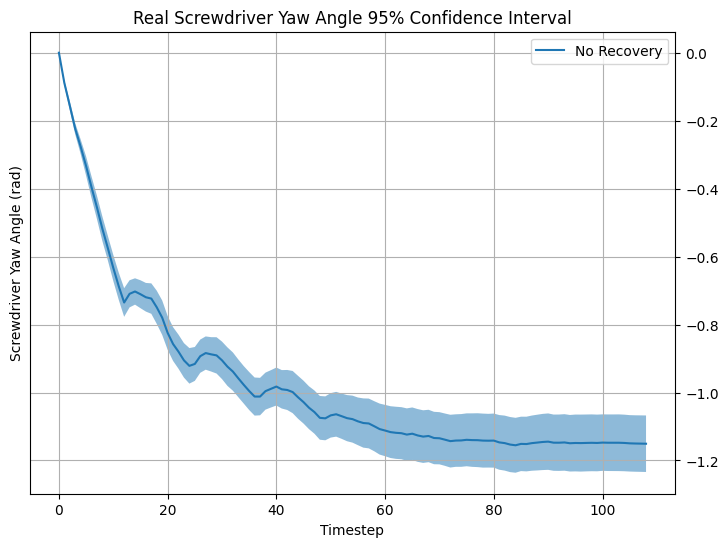

In [ ]:
from IPython.display import clear_output
# while True:
# Clear cell output
clear_output(wait=True)
data_exec = {}
t = 3
for key, name in [
                # ('allegro_screwdriver_recovery_data_pi_6_fixed_cpc', 'allegro_screwdriver_recovery_data_pi_6_fixed_cpc'),
                # ('recovery_model_old_no_perturb_during_recovery', 'allegro_screwdriver_recovery_model_fixed_cpc_eval'),
                # ('recovery_model_old_perturb_during_recovery', 'allegro_screwdriver_recovery_model_fixed_cpc_eval_perturb_during_recovery'),
                
                # ('recovery_model_new_perturb_during_recovery',
                #  'allegro_screwdriver_recovery_model_fixed_rand_pct_eval'),
                # ('contact_mode_diffusion_ablation',
                # 'allegro_screwdriver_recovery_model_mlp_ablation_fixed_rand_pct_eval'),
                
                
                # ('recovery_data_gen_pi_2', 
                #  'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2'),
                # ('recovery_data_gen_pi_2_9000', 
                #  'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2_9000'),
                # ('recovery_data_gen_pi_2_9000_185_thresh', 
                #  'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2_9000_185_thresh'),
                # ('recovery_data_gen_pi_2_9000_160_thresh', 
                #  'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2_9000_160_thresh'),
                # ('recovery_data_gen_pi_2_9000_160_thresh_double_cost', 
                #  'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2_9000_160_thresh_double_cost'),
                # ('recovery_data_gen_pi_2_9000_160_thresh_double_cost_100_warm', 
                #  'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2_9000_160_thresh_double_cost_100_warm'),
                # ('recovery_data_gen_pi_2_9000_160_thresh_double_cost_100_warm_no_diff_init', 
                #  'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2_9000_160_thresh_double_cost_100_warm_no_diff_init'),
                # ('recovery_data_gen_pi_2_9000_160_thresh_no_perturb', 
                #  'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2_9000_160_thresh_no_perturb'),
                # ('recovery_data_gen_pi_2_9000_160_thresh_no_perturb_cpc_.005', 'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2_9000_160_thresh_no_perturb_cpc_.005'),
                # ('recovery_data_gen_pi_2_9000_160_thresh_no_perturb_cpc_.005_smooth_100', 'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2_9000_160_thresh_no_perturb_cpc_.005_smooth_100'),
                # ('recovery_data_gen_pi_2_9000_160_thresh_no_perturb_cpc_.005_smooth_100_cost_div_10', 'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2_9000_160_thresh_no_perturb_cpc_.005_smooth_100_cost_div_10'),
                # ('recovery_data_gen_pi_2_9000_160_thresh_no_perturb_kinematics_x_10',
                #  'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2_9000_160_thresh_no_perturb_kinematics_x_10'),
                # ('recovery_data_gen_pi_2_9000_low_budget', 'allegro_screwdriver_recovery_data_pi_6_rand_pct_.25_1.75_N_r_.5_1_pi_2_9000_160_thresh_low_budget')
                # ('No Recovery', 'allegro_screwdriver_safe_rl_recovery_data_pi_2_damping_.1'),
                ('Likelihood MPPI Recovery', 'allegro_screwdriver_likelihood_mppi_recovery')
                ]:
    data_exec[key] = {}
    all_x, all_data = get_traj(name)

    data_exec[key] = {**data_exec[key], **all_data}
print()

delta_likelihood_analysis(data_exec, 
                        {    
                            # 'allegro_screwdriver_recovery_data_pi_6_fixed_cpc': ['allegro_screwdriver_recovery_data_pi_6_fixed_cpc'],
                            # 'recovery_model_old_no_perturb_during_recovery': ['recovery_model_old_no_perturb_during_recovery'],
                            # 'recovery_model_old_perturb_during_recovery': ['recovery_model_old_perturb_during_recovery'],
                            # 'recovery_model_new_perturb_during_recovery': ['recovery_model_new_perturb_during_recovery'],
                            # 'contact_mode_diffusion_ablation': ['contact_mode_diffusion_ablation'],
                            # 'recovery_data_gen_pi_2': ['recovery_data_gen_pi_2'],
                            # 'recovery_data_gen_pi_2_9000': ['recovery_data_gen_pi_2_9000'],
                            # 'recovery_data_gen_pi_2_9000_185_thresh': ['recovery_data_gen_pi_2_9000_185_thresh'],
                            # 'recovery_data_gen_pi_2_9000_160_thresh': ['recovery_data_gen_pi_2_9000_160_thresh'],
                            # 'recovery_data_gen_pi_2_9000_160_thresh_double_cost': ['recovery_data_gen_pi_2_9000_160_thresh_double_cost'],
                            # 'recovery_data_gen_pi_2_9000_160_thresh_double_cost_100_warm': ['recovery_data_gen_pi_2_9000_160_thresh_double_cost_100_warm'],
                            # 'recovery_data_gen_pi_2_9000_160_thresh_double_cost_100_warm_no_diff_init': ['recovery_data_gen_pi_2_9000_160_thresh_double_cost_100_warm_no_diff_init'],
                            # 'recovery_data_gen_pi_2_9000_160_thresh_no_perturb': ['recovery_data_gen_pi_2_9000_160_thresh_no_perturb'],
                            # 'recovery_data_gen_pi_2_9000_160_thresh_no_perturb_cpc_.005': ['recovery_data_gen_pi_2_9000_160_thresh_no_perturb_cpc_.005'],
                            # 'recovery_data_gen_pi_2_9000_160_thresh_no_perturb_cpc_.005_smooth_100': ['recovery_data_gen_pi_2_9000_160_thresh_no_perturb_cpc_.005_smooth_100'],
                            # 'recovery_data_gen_pi_2_9000_160_thresh_no_perturb_cpc_.005_smooth_100_cost_div_10': ['recovery_data_gen_pi_2_9000_160_thresh_no_perturb_cpc_.005_smooth_100_cost_div_10'],
                            # 'recovery_data_perturb_during_recovery': ['recovery_data_perturb_during_recovery'],
                            # 'recovery_model_new_perturb_during_recovery': ['recovery_model_new_perturb_during_recovery'],
                            # 'recovery_data_gen_pi_2_9000_160_thresh_no_perturb_kinematics_x_10': ['recovery_data_gen_pi_2_9000_160_thresh_no_perturb_kinematics_x_10'],
                            # 'recovery_data_gen_pi_2_9000_low_budget': ['recovery_data_gen_pi_2_9000_low_budget']
                            'Likelihood MPPI Recovery': ['Likelihood MPPI Recovery']
                        })
t = 3
stat = 'mean'
dofs_to_plot = ['yaw']

keys_exec = [
            # 'recovery_model_old_no_perturb_during_recovery',
            # 'recovery_model_old_perturb_during_recovery',
            # 'recovery_model_new_perturb_during_recovery',
            # 'contact_mode_diffusion_ablation',
            # 'recovery_data_gen_pi_2',
            # 'recovery_data_gen_pi_2_9000',
            # 'recovery_data_gen_pi_2_9000_185_thresh',
            # 'recovery_data_gen_pi_2_9000_160_thresh',
            # 'recovery_data_gen_pi_2_9000_160_thresh_double_cost',
            # 'recovery_data_gen_pi_2_9000_160_thresh_double_cost_100_warm',
            # 'recovery_data_gen_pi_2_9000_160_thresh_double_cost_100_warm_no_diff_init',
            # 'recovery_data_gen_pi_2_9000_160_thresh_no_perturb',
            # 'recovery_data_gen_pi_2_9000_160_thresh_no_perturb_cpc_.005',
            # 'recovery_data_gen_pi_2_9000_160_thresh_no_perturb_cpc_.005_smooth_100',
            # 'recovery_data_gen_pi_2_9000_160_thresh_no_perturb_cpc_.005_smooth_100_cost_div_10',
            # 'recovery_data_gen_pi_2_9000_160_thresh_no_perturb_kinematics_x_10'
            # 'recovery_data_gen_pi_2_9000_low_budget',
            # 'No Recovery'
            'Likelihood MPPI Recovery'
            ]
means = gen_plot_screwdriver_angle(data_exec, keys_exec, 'traj', dof_to_plot=dofs_to_plot, stat=stat, label_dict=None)

# % increase in mean compared to ablation
# for key in keys_exec:
#     if key == 'contact_mode_diffusion_ablation':
#         continue
#     print(key, (means[key] - means['contact_mode_diffusion_ablation']) / means['contact_mode_diffusion_ablation'] * 100)
    # time.sleep(10)

In [ ]:
# Our method results
# Total points: 610
# Total points block: 359
# recovery_model_new_perturb_during_recovery: 41.31% of one-step recoveries were successful
# recovery_model_new_perturb_during_recovery: 80.78% of recoveries were eventually successful
# recovery_model_new_perturb_during_recovery: 95% CI for number of recovery attempts: 1.70 +/- 0.18
# recovery_model_new_perturb_during_recovery: Drop %: 9.84%
# recovery_model_new_perturb_during_recovery: Drop % per recovery block: 16.71%